# Microgrid with PV, battery and a dispatchable generator

Demo of main data structures and functions of [Microgrids.jl](https://github.com/Microgrids-X/Microgrids.jl).
Main steps are:

1. Describe the Microgrid project and components
2. Simulation the Microgrid
3. Analyze simulation results (technical and economic)

In [1]:
using Microgrids
using CSV, DataFrames, Statistics

[ Info: Precompiling Microgrids [bd581358-d3fa-499e-a26e-e70307242c03]


In [2]:
using PyPlot # For plotting only. Can be skipped or commented out

In [3]:
with_plots = isdefined(Main, :PyPlot)

true

## Load time series data

Read load and solar data:
- Load: real consumption data at an hourly timestep from the [Ushant island](https://en.wikipedia.org/wiki/Ushant) in 2016
- Solar and wind data comes from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html). See [data/SOURCES.md](data/SOURCES.md).

In [4]:
data = DataFrame(CSV.File("$(@__DIR__)/data/Ouessant_data_2016.csv"))

# Simulation steps
nsteps = length(data.Load)
@assert(nsteps == 8760) # 1 year at an hourly timestep

# Split load and solar data:
Pload = data.Load # kW
Ppv1k =  data.Ppv1k ./ 1000; # convert to kW/kWp
mean(Ppv1k) # yearly capacity factor of 12% (quite low in 2016 in Ouessant)

0.1182560696347032

Display load time series

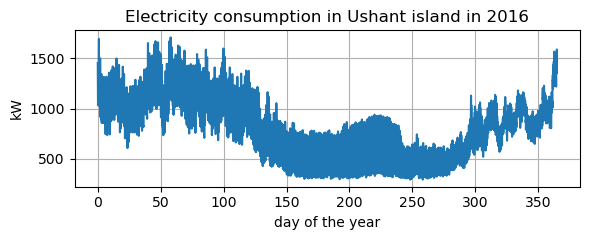

In [5]:
td = collect((0:nsteps-1)/24) # time in days

if with_plots
    fig, ax = plt.subplots(1,1, figsize=(6,2.5))
    ax.plot(td, Pload, label="load")
    
    ax.grid(true)
    ax.set(
        title="Electricity consumption in Ushant island in 2016",
        ylabel="kW",
        xlabel="day of the year"
    )
    fig.tight_layout()
end

## Microgrid description

Describe the Microgrid project and its components using dedicated data structures

### Project parameters

Financial parameters like discount rate, as well as technical details like the timestep of input data.

In [6]:
lifetime = 25 # yr
discount_rate = 0.05
timestep = 1. # h

project = Project(lifetime, discount_rate, timestep, "€")

Project(25, 0.05, 1.0, "€")

Parameters chosen to be common to all Components (but they could differ)

- replacement price relative to initial investment price
- salvage price relative to initial investment price

In [7]:
replacement_price_ratio = 1.0
salvage_price_ratio = 1.0;

### Dispatchable generator (Diesel)

Used as last recourse when there is not enough solar production and the battery is empty

In [8]:
power_rated_gen = 1800.  # rated power (kW) → /2 to see some load shedding
fuel_intercept = 0.0 # fuel curve intercept (L/h/kW_max)
fuel_slope = 0.240 # fuel curve slope (L/h/kW)
fuel_price = 1. # fuel price ($/L)
investment_price_gen = 400. # initial investiment price ($/kW)
om_price_gen = 0.02 # operation & maintenance price ($/kW/h of operation)
lifetime_gen = 15000. # generator lifetime (h)
load_ratio_min = 0.0 # minimum load ratio ∈ [0,1]
fuel_unit = "L" # fuel quantity unit (used in fuel price and consumption curve parameters)

generator = DispatchableGenerator(power_rated_gen,
    fuel_intercept, fuel_slope, fuel_price,
    investment_price_gen, om_price_gen, lifetime_gen,
    load_ratio_min,
    replacement_price_ratio, salvage_price_ratio, fuel_unit)

DispatchableGenerator{Float64}(1800.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L")

### Battery energy storage

Used as a buffer between the solar production and the consumption

In [9]:
energy_rated_sto = 9000. # rated energy capacity (kWh)
investment_price_sto = 350. # initial investiment price ($/kWh)
om_price_sto = 10. # operation and maintenance price ($/kWh/y)
lifetime_sto = 15. # calendar lifetime (y)
lifetime_cycles = 3000. # maximum number of cycles over life (1)
charge_rate = 1.0 # max charge power for 1 kWh (kW/kWh = h^-1)
discharge_rate = 1.0 # max discharge power for 1 kWh (kW/kWh = h^-1)
loss_factor_sto = 0.05 # linear loss factor α (round-trip efficiency is about 1 − 2α) ∈ [0,1]
SoC_min = 0. # minimum State of Charge ∈ [0,1]
SoC_ini = 0. # initial State of Charge ∈ [0,1]

battery = Battery(energy_rated_sto,
    investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
    charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
    replacement_price_ratio, salvage_price_ratio)

Battery{Float64}(9000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 0.0, 1.0, 1.0)

### Photovoltaic generation

Used in priority to feed the load. PV is proportional to the irradiance data the previous section

In [10]:
power_rated_pv = 6000. # rated power (kW)
irradiance = Ppv1k # global solar irradiance incident on the PV array (kW/m²)
investment_price_pv = 1200. # initial investiment price ($/kW)
om_price_pv = 20.# operation and maintenance price ($/kW)
lifetime_pv = 25. # lifetime (y)
derating_factor_pv = 1.0 # derating factor (or performance ratio) ∈ [0,1]"

photovoltaic = Photovoltaic(power_rated_pv, irradiance,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv,
    replacement_price_ratio, salvage_price_ratio)

Photovoltaic{Float64}(6000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0)

Display PV production time series (which is proportional to the rated power of the plant `power_rated_pv`)
- PV production is computed by calling the `production` method on the `Photovoltaic` instance

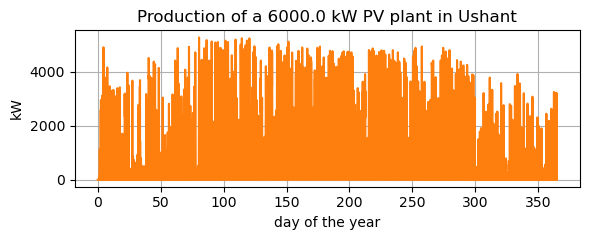

In [11]:
if with_plots
    fig, ax = plt.subplots(1,1, figsize=(6,2.5))

    ax.plot(td, production(photovoltaic), "C1")

    ax.grid(true)
    ax.set(
        title="Production of a $power_rated_pv kW PV plant in Ushant",
        ylabel="kW",
        xlabel="day of the year"
    );
    fig.tight_layout()
end

### Microgrid data structure

the `Microgrid` data structure groups:
- project parameters
- load time series
- all components: generator, battery, renewable power generators

In [12]:
microgrid = Microgrid(project, Pload, generator, battery, [photovoltaic]);

## Simulate the microgrid

launched with the `simulate` method:

In [13]:
oper_traj, oper_stats, mg_costs = simulate(microgrid);

in details, the simulation is done in two stages:

1. simulate the **operation**, in particular the energy flow at an hourly timestep between components: 
    - generates operation statistics as `OperationStats` data structure
    - records operation the trajectories of operation variables
2. evaluate the **economic cost** of the project, based on its description and on the operation statistics:
    - generates cost data as `MicrogridCosts` data structure

these successive stages can be run manually with their dedicated functions (see `simulate` code)

Microgrid simulation code is optimized to run in less than 1 ms:

(you can use [Benchmarktools](https://juliaci.github.io/BenchmarkTools.jl/)'s `@btime` for more accurate timing results)

In [14]:
@time oper_traj, oper_stats, mg_costs = simulate(microgrid); # 

  0.000321 seconds (132 allocations: 691.719 KiB)


## Analyze microgrid simulation results

### Technical performance

Operation statistics are in `oper_stats` (`OperationStats` data structure) with fields such as `renew_rate`, `shed_energy`...

In [15]:
oper_stats.renew_rate # in [0,1]

0.5874028997693115

In [16]:
oper_stats.gen_fuel # liters

670880.8054857135

served energy (per year), versus desired load:

In [17]:
oper_stats.served_energy/1e6, sum(Pload)*timestep/1e6 # GWh

(6.774979, 6.774979)

In [19]:
oper_stats.shed_rate # in [0,1]

0.0

In [20]:
oper_stats.gen_hours # hours of dispatchable generator operation

3327.0

In [21]:
oper_stats.storage_cycles

209.0837298802562

In [22]:
oper_stats

OperationStats(6.774979e6, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7953366895238096e6, 3327.0, 670880.8054857135, 209.0837298802562, 1.975841247368421e6, 1.7876658904761905e6, 188175.35689223045, 2.0477213526315792e6, 4569.3, 0.32945193426387326, 6.21553902e6, 4.1678176673684204e6, 0.5874028997693115)

### Economic performance

`mg_costs` output is of type `MicrogridCosts` which contains:

- two highlevel cost indicators: Net present Cost `npc` and Levelized Costs of Electricity `lcoe`
- a break down of cost factors the entire project in `system`: initial investment, fuel... (`CostFactors` structure)
- a detailed of the cost factors for each component (also `CostFactors` structures)

In [23]:
mg_costs.npc/1e6 # M$

28.35300075842167

In [24]:
mg_costs.lcoe # $/kWh

0.2969330348650438

`CostFactors` structures support arithmetic (+,*,/) and rounding

In [25]:
round(mg_costs.system/1e6; digits=2) # in M$

CostFactors(28.35, 11.07, 3.52, 4.65, 9.46, -0.34)

Definition of the fields of cost factors

(remark: `npc` is in fact equal to `system.total`)

In [26]:
fieldnames(CostFactors)

(:total, :investment, :replacement, :om, :fuel, :salvage)

For illustration, we can check that fuel costs of the systems comes from the generator:

In [27]:
round(mg_costs.generator.fuel/1e6; digits=2)

9.46

### Operation trajectories

`oper_traj` is of type `OperationTraj` with fields such as `Pgen` (generator power), `Pbatt` (battery power)...

Display operation trajectories

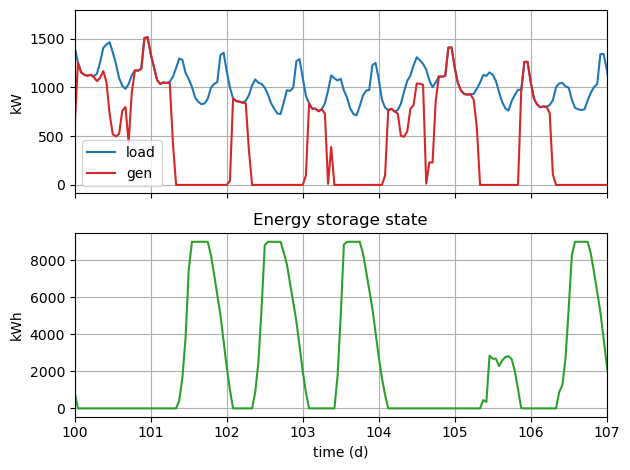

In [28]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=true)
ax1.plot(td, Pload, label="load")
ax1.plot(td, oper_traj.Pgen, "C3", label="gen")
#ax1.plot(t, oper_traj.Pbatt)
ax2.plot(td, oper_traj.Ebatt[1:end-1], "C2")

ax1.legend()
ax1.grid(true)
ax1.set(
    ylabel="kW"
)
ax2.grid(true)
ax2.set(
    title="Energy storage state",
    xlabel="time (d)",
    ylabel="kWh"
)

d0 = 100
plt.xlim(d0,d0+7)
fig.tight_layout()

--- 

## Microgrid sizing optimization

In [46]:
using NLopt
using Printf

### Setting the cost function (criterion) to be optimized

Encapsulation of the microgrid simulation in 3 stages (could be done in one for compactness, but sacrificing composability):

1. Simulation of Microgrid project of size `x`
2. Extract KPIs of interest to build a multi-objective criterion: here lcoe and shedding rate
3. Combine these KPIs as one mono-objective criterion: here LCOE + penalty if shedding rate > shed_max

In [30]:
"""Simulate the performance of a Microgrid project of size `x`
with x=[power_rated_gen, energy_rated_sto, power_rated_pv]

Returns stats, costs
"""
function simulate_microgrid(x)
    # Split decision variables (converted MW → kW): 
    power_rated_gen = x[1]*1000
    energy_rated_sto = x[2]*1000
    power_rated_pv = x[3]*1000

    # Create components
    gen = DispatchableGenerator(power_rated_gen,
        fuel_intercept, fuel_slope, fuel_price,
        investment_price_gen, om_price_gen, lifetime_gen,
        load_ratio_min,
        replacement_price_ratio, salvage_price_ratio, fuel_unit)
    batt = Battery(energy_rated_sto,
        investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
        charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
        replacement_price_ratio, salvage_price_ratio)
    pv = Photovoltaic(power_rated_pv, irradiance,
        investment_price_pv, om_price_pv,
        lifetime_pv, derating_factor_pv,
        replacement_price_ratio, salvage_price_ratio)
    mg = Microgrid(project, Pload, gen, batt, [pv])

    # Launch simulation:
    traj, stats, costs = simulate(mg)
 
    return stats, costs
end

"Multi-objective criterion for microgrid performance: lcoe, shedding rate"
function obj_multi(x)
    stats, costs = simulate_microgrid(x)
    # Extract KPIs of interest
    lcoe = costs.lcoe # $/kWh
    shed_rate = stats.shed_rate; # in [0,1]
    return lcoe, shed_rate
end

"""Mono-objective criterion: LCOE + penalty if shedding rate > shed_max

`shed_max` should be in  [0,1[
"""
function obj(x, grad, shed_max, w_shed_max=1e5)
    lcoe, shed_rate = obj_multi(x)
    over_shed = shed_rate - shed_max
    if over_shed > 0.0
        penalty = w_shed_max*over_shed
    else
        penalty = 0.0
    end
    J = lcoe + penalty
end

obj

test the objective function:

- baseline sizing from above

In [31]:
shed_max = 0.01 # in [0,1]
x = [power_rated_gen energy_rated_sto power_rated_pv]/1000
obj_multi(x), obj(x, [], shed_max)

((0.2969330348650438, 0.0), 0.2969330348650438)

- large enough generator alone: perfect quality of service, but high LCOE (0.35 \$/kWh)
- small solar PV alone: low LCOE (0.10 \$/kWh), but extremely bad quality of service → huge penalty

In [32]:
x = [power_rated_gen 0. 0.]/1000
obj_multi(x), obj(x, [], shed_max)

((0.35286658877836535, 0.0), 0.35286658877836535)

In [33]:
x = [0. 0. 500]/1000
obj_multi(x), obj(x, [], shed_max)

((0.10149685980966677, 0.923547868561659), 91354.8883530257)

### Setting up the optimization problem

bounds of the design space and starting point: derived from maximal load power

In [34]:
Pload_max = maximum(Pload)

xmin = [1e-3, 0., 0.]
x0 = [1.0, 5.0, 3.0] * (Pload_max/1000)
xmax = [1.2, 10.0, 10.0] * (Pload_max/1000)

3-element Vector{Float64}:
  2.0484
 17.07
 17.07

Check xmax on cost function

In [35]:
obj_multi(xmax), obj(xmax, [], shed_max)

((0.43640746371458755, 0.0), 0.43640746371458755)

In [41]:
"""Optimize sizing of 

`algo` could be one of LN_SBPLX, GN_DIRECT, GN_ESCH...
"""
function optim_mg(x0, shed_max, algo=:LN_SBPLX, maxeval=1000, xtol_rel=1e-4, srand=1)
    nx = 3 # number of optim variables
    opt = Opt(algo, nx)
    NLopt.srand(srand)
    
    opt.lower_bounds = xmin
    opt.upper_bounds = xmax
    opt.min_objective = (x, grad) -> obj(x, grad, shed_max)
    opt.xtol_rel = xtol_rel
    opt.maxeval = maxeval
    
    (fopt, xopt, ret) = optimize(opt, x0)
    return xopt, ret, opt.numevals
end

optim_mg

### Optimization

In [73]:
algo = :GN_DIRECT # could be one of LN_SBPLX, GN_DIRECT, GN_ESCH...
shed_max = 0.01 # in [0,1]
xopt, ret, numevals = optim_mg(x0, shed_max, algo)

# optional local "polishing":
#algo_polish = :LN_SBPLX
#xopt, ret, numevals = optim_mg(xopt, shed_max, algo_polish)

@printf("%s after %d iterations. \nx*=", ret, numevals)
println(round.(xopt*1000; digits=1)) # kW
lcoe_opt, shed_rate_opt = obj_multi(xopt)
println("LCOE*: ", lcoe_opt)
println("shed*: ", shed_rate_opt)

MAXEVAL_REACHED after 1000 iterations. 
x*=[1175.0, 6684.4, 4006.7]
LCOE*: 0.26984046654810656
shed*: 0.009999981025867922


#### Some results for 1% max shedding rate

- SUBPLX:    0.272 97 \$/kWh with shedding OK in 223 iter. x* = [1157.7, 7100.7, 5047.7]
- GN_ESCH: 0.274 786 \$/kWh with shedding OK in 1000 iter. x*=[1158.6, 8535.0, 5121.0]
- GN_DIRECT: 0.269 840 \$/kWh with shedding OK in 1000 iter. x* = [1175.0, 6684.4, 4006.7] → *best algorithm choice so far*
    - "polishing" with SUBPLX: 0.269 838 \$/kWh in 148 extra iter. x* = [1175.0, 6678.6, 4006.7]

#### Performance of the optimization

About 0.3 s for 1000 iterations

In [74]:
@time xopt, ret, numevals = optim_mg(x0, shed_max, :GN_DIRECT, 1000)

  0.296329 seconds (126.02 k allocations: 673.119 MiB, 8.82% gc time)


([1.1749569331308651, 6.684393723856458, 4.006713285200051], :MAXEVAL_REACHED, 1000)

Optimization time to simulation time: Toptim ~ Tsim × neval

In [75]:
@time obj_multi(x0);

  0.000615 seconds (123 allocations: 689.203 KiB)


### How we image the optimization interface in a future version...

Desirable feature: dynamically select which variables are optimized (e.g. using `getproperty` to dynamically access structure fields...)

In [ ]:
opti_params = [
    ([:generator,:power_rated], 1800.0),
    ([:battery,:energy_max], 1800.0)
]
#optim_mg(mg0, opti_params)